<a href="https://colab.research.google.com/github/ag8/backdoor-colabs/blob/main/Joint_3_SAT_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 3-SAT Verifier Transformer in Tracr

I implement a [3-SAT](https://en.wikipedia.org/wiki/Boolean_satisfiability_problem) verifier as a Transformer circuit by using [RASP](https://arxiv.org/pdf/2106.06981.pdf) programs in [Tracr](https://github.com/google-deepmind/tracr/tree/main/tracr/rasp). This can serve as a toy example for a Transformer that is hard to reverse, and showcase theoretical cases that would be difficult for algorithms such as [Greedy Coordinate Descent](https://arxiv.org/pdf/2307.15043.pdf) (GCG). Any problem in NP can be reduced to 3-SAT, including ones that seem to be hard in the average case, e.g. integer factoring, (which is believed highly unlikely to be NP-complete).

RASP is a programming language that allows implementing handcrafted Transformer circuits. It can be used to to make Transformers perform simple algorithms such as reversing a string in a way that achieves length-generalization. For a great introduction on RASP, see this blog: https://srush.github.io/raspy/.

This notebook is made for developing and experimenting with Tracr models. It adapts Neel Nanda's [Tracr to TransformerLens Converter notebook](https://colab.research.google.com/github/neelnanda-io/TransformerLens/blob/main/demos/Tracr_to_Transformer_Lens_Demo.ipynb) and Tracr's [example visualisation notebook](https://github.com/google-deepmind/tracr/blob/main/tracr/examples/Visualize_Tracr_Models.ipynb). A TransformerLens model can be accessed at the end of the 'Build the TransformerLens model' section. In this version I've added some helper functions and bug fixes.

If you have any suggested improvements or bug fixes, feel free to message or email me!

# Install dependencies

This might take a few minutes

In [ ]:
%pip install transformer_lens
%pip install git+https://github.com/deepmind/tracr

In [ ]:
#@title Imports

from transformer_lens import HookedTransformer, HookedTransformerConfig
import einops
import torch
import numpy as np
import math
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

from tracr.rasp import rasp
from tracr.compiler import compiling, lib

from typing import Iterable, Callable, Any
import numpy.typing as npt


# The default of float16 can lead to discrepancies between outputs of
# the compiled model and the RASP program.
jax.config.update('jax_default_matmul_precision', 'float32')

# originally developed for these versions:
  # Python 3.10.12
  # transformer_lens==1.14.0
  # git+https://github.com/google-deepmind/tracr/tree/9ce2b8c82b6ba10e62e86cf6f390e7536d4fd2cd

# Define helper functions

In [ ]:
#@title Helper functions: RASP programming


from tracr.compiler.lib import make_count
def count_true_vals(bools: rasp.SOp) -> rasp.SOp:
  return make_count(bools, True)

def make_all_true() -> rasp.SOp:
  return rasp.Map(lambda i: True, rasp.indices).named("all_trues")

def make_length() -> rasp.SOp:
  return rasp.SelectorWidth(all_true_selector).named("length")

def hardcode_to_SOp(s: Iterable) -> rasp.SOp:
  return rasp.Map(lambda i: s[i] if i<len(s) else "_", rasp.indices).named("hardcoded_value")

def elementwise_f(f:Callable, a: rasp.SOp) -> rasp.SOp:
  """applies function f to each element in SOp"""
  return rasp.Map(f, a).named("elementwise_f")

def elementwise_EQ(a: rasp.SOp, b: rasp.SOp) -> rasp.SOp:
  return rasp.SequenceMap(lambda x, y: x == y, a, b).named("elementwise_EQ")

def elementwise_OR(a: rasp.SOp, b: rasp.SOp) -> rasp.SOp:
  return rasp.SequenceMap(lambda x, y: x or y, a, b).named("elementwise_OR")

def elementwise_AND(a: rasp.SOp, b: rasp.SOp) -> rasp.SOp:
  return rasp.SequenceMap(lambda x, y: x and y, a, b).named("elementwise_AND")

def elementwise_subtract(a: rasp.SOp, b: rasp.SOp) -> rasp.SOp:
  return rasp.SequenceMap(lambda x, y: x - y, a, b).named("elementwise_subtract")

def elementwise_AND_for_n_SOps(sop_list)->rasp.SOp:
  if len(sop_list)==1: return sop_list[0]
  return elementwise_AND(sop_list[0], elementwise_AND_for_n_SOps(sop_list[1:]))

def check_if_all_true(bools: rasp.SOp) -> rasp.SOp:
  """check if all bools are True (numerically stable)"""
  inverted_bools = rasp.Map(lambda x: not x, bools).named("inverted_bools")
  any_missing  = rasp.numerical(rasp.Map(lambda x: x, inverted_bools).named("any_missing"))
  select_all = rasp.Select(rasp.indices, rasp.indices, rasp.Comparison.TRUE).named("select_all")
  has_missing = rasp.numerical(rasp.Aggregate(select_all, any_missing, default=0)).named("has_missing")
  not_has_missing = (~has_missing).named("not_has_missing")
  is_all_true = rasp.categorical(not_has_missing).named("is_all_true")
  return is_all_true

def format_inputs(input: Iterable) -> list:
  "converts input to a list and adds a beginning-of-sentence token"
  return [compiler_bos] + list(input)

def evf(rasp_object: rasp.RASPExpr) -> None:
  global test_input
  """
  evaluate a rasp object fast for debugging purposes
  similar to ev but only uses the faster rasp.evaluate
  Warning: this might return a different result than the Tracr model
  E.g. it allows using some unimplemented features such as selectorOR
  """

  inp = format_inputs(test_input)[1:]
  result = rasp.evaluate(rasp_object, inp)
  print(f"evaluated {rasp_object.name} on test_input:", result, flush=True)

def ev(rasp_object: rasp.RASPExpr) -> None:
  global test_input, max_seq_len, vocab, compiler_bos, compiler_pad
  """
  evaluate a rasp object for debugging purposes
  e.g. write ev(is_shorter_than_n) instead of print(is_shorter_than_n)
  Does not work for constant objects that do not depend on tokens in any way

  Also see evf which is faster version but in some cases returns a different
  result than the real Tracr model
  """

  inp = format_inputs(test_input)[1:]
  result_fast = rasp.evaluate(rasp_object, inp)
  test_tracr_model = compiling.compile_rasp_to_model(rasp_object, vocab, max_seq_len, False, compiler_bos, compiler_pad)
  test_tracr_decoded_output = test_tracr_model.apply(format_inputs(test_input)).decoded
  result_accurate = test_tracr_decoded_output[1:]  # cut "BOS" token

  print(f"evaluated {rasp_object.name} on test_input:", result_accurate, flush=True)
  if result_fast!=result_accurate:
    print("WARNING: result_accurate and result_fast are different!")
    print(f"\Accurate: {result_accurate} \nFast: {result_fast}")


# Useful constants:
all_true = make_all_true()
all_true_selector = rasp.Select(all_true, all_true, rasp.Comparison.TRUE).named("all_true_selector")
length = make_length()
alphabet = "abcdefghijklmnopqrstuvwxyz"
numbers = "0123456789"

# Tracr compiler settings:
compiler_bos = "BOS"
compiler_pad = "PAD"
causal = False  # if True, outputs a model with causal masking.
mlp_exactness = 100
# mlp_exactness controls the approximation of the MLP layers. In theory,
# larger values yield a better approximation. But too large values can cause
# numerical issues due to large parameter norms. Reasonable values are between 1 and 100.

# Password Checker

The simplest backdoor trigger. Brute force black-box testing would not work, but GCG would probably succeed.

In [ ]:
def check_if_all_true_and_len_is_n(bools: rasp.SOp, n: int) -> rasp.SOp:
  true_counts = count_true_vals(bools)
  is_all_true = true_counts == n
  return is_all_true.named("check_if_all_true_and_len_is_n")

def check_password(hardcoded_password: str) -> rasp.SOp:
  """outputs all True if the password is correct, else all False"""
  pw = hardcode_to_SOp(hardcoded_password)
  pw_bools = elementwise_EQ(rasp.tokens, pw)
  output = check_if_all_true_and_len_is_n(pw_bools, len(hardcoded_password))
  return output.named("pwcheck")

def check_password_gradual(hardcoded_password: str) -> rasp.SOp:
  """
  outputs a higher number if more password letters are closer
  to the correct letters in unicode code - using ord(char)
  this should be easier for GCG since it receives feedback from the model
  """
  # minimise the distance from the correct pw
  pw = hardcode_to_SOp(hardcoded_password).named("hardcoded_password")
  in_ords = elementwise_f(ord, rasp.tokens).named("in_ords")
  pw_ords = elementwise_f(ord, pw).named("pw_ords")
  distance = rasp.numerical(elementwise_f(abs, elementwise_subtract(in_ords, pw_ords))).named("distance")
  n_correct =  rasp.numerical(distance == 0).named("n_correct")
  all_zeros = rasp.Map(lambda i: 0, rasp.indices).named("all_zeros")
  pw_correctness = rasp.numerical(rasp.Aggregate(all_true_selector, n_correct, default=0))
  return pw_correctness.named("pw_correctness")


test_input = "paxbwordd"

program = check_password_gradual(hardcoded_password="password")
max_seq_len = max(20, len(test_input))
vocab = set(list(alphabet + alphabet.upper() + numbers))
tracr_model = compiling.compile_rasp_to_model(program, vocab, max_seq_len, False, compiler_bos, compiler_pad)
tracr_decoded_output = tracr_model.apply(format_inputs(test_input)).decoded

print("test input:", test_input)
print("decoded_output:", tracr_decoded_output)

test input: paxbwordd
decoded_output: ['BOS', 0.6666666865348816, 0.6666666865348816, 0.6666666865348816, 0.6666666865348816, 0.6666666865348816, 0.6666666865348816, 0.6666666865348816, 0.6666666865348816, 0.6666666865348816]


# 3-SAT verifier

Checks whether the input variables satisfy a 3-SAT problem encoded in the transformer. Optimising input to get this transformer to output "True" should not work unless it can solve NP-complete problems.

In [ ]:
def bool_to_one_hot(var: bool) -> str:
  """one-hot encodings for boolean inputs"""
  if var==1: return "01"
  elif var==0: return "10"
  else: raise ValueError('var must be True or False')

def bools_str_to_one_hot(vars: str) -> str:
  """e.g. "1101" -> "01011001" """
  one_hot_bools = [bool_to_one_hot(bool(int(i))) for i in vars]
  one_hot_bools_string = "".join(one_hot_bools)
  one_hot_bools_ints = [int(i) for i in one_hot_bools_string]
  return one_hot_bools_ints

def get_key_value(i: int) -> int:
    """maps [0,1,2,3,4,...] -> [-1,1,-2,2,-3,...]"""
    sign = -1 if i%2==0 else 1
    value = i//2 + 1
    return sign * value

def swap_indices_fn(i: int) -> int:
  """[0, 1, 2, ...] -> [2, 1, 4, 3, 6, 5 ...]"""
  is_even = i%2==0
  if is_even: return i+1
  else: return i-1

def check_if_len_smaller_than_n(n: int) -> rasp.SOp:
  inverted_one_hot_n = hardcode_to_SOp([True]*(n-1)+[False]).named("inverted_one_hot_n")
  inverted_one_hot_n = rasp.categorical(rasp.Map(lambda x: bool(x), inverted_one_hot_n)).named("inverted_one_hot_n")
  is_shorter_than_n = check_if_all_true(inverted_one_hot_n).named("is_shorter_than_n")
  return is_shorter_than_n

def verify_input_correctness(n_variables: int)-> rasp.SOp:
  """chech that input len >= n_variables * 2 and input bools are one-hot-encoded"""
  swapped_pairs_indices = rasp.Map(lambda x: swap_indices_fn(x), rasp.indices).named("swapped_pairs_indices")
  other_var_selector = rasp.Select(rasp.indices, swapped_pairs_indices, rasp.Comparison.EQ).named("other_var_selector")
  other_var = rasp.Aggregate(other_var_selector, rasp.tokens, default=None).named("other_var")
  var_1_xor_var_2 = rasp.SequenceMap(lambda x, y: bool(x) != bool(y), rasp.tokens, other_var).named("var_1_xor_var_2")
  is_correct_length = (~check_if_len_smaller_than_n(n_variables*2)).named("is_correct_length")
  input_pos_is_valid = elementwise_AND(var_1_xor_var_2, is_correct_length).named("input_pos_is_valid")
  input_is_valid = check_if_all_true(input_pos_is_valid).named("input_is_valid")
  return input_is_valid

def fetch_var_i_for_clauses(clauses, i) -> rasp.SOp:
  """takes a batch of clauses and variable position i (1,2 or 3), returns"""
  queries = hardcode_to_SOp(clauses[:,i]).named(f"clauses_var_{i}")
  clauses_var_i_selector = rasp.Select(var_keys, queries, rasp.Comparison.EQ).named(f"clause_var_{i}_selector")
  clauses_var_i_averaged = rasp.Aggregate(clauses_var_i_selector, rasp.tokens).named(f"clause_var_{i}_averaged")
  clauses_var_i_detected = rasp.categorical(rasp.Map(lambda x: x==1, clauses_var_i_averaged)).named(f"clauses_var_{i}_detected")
  return clauses_var_i_detected

def verify_2n_clause_batch(clauses: np.array, n_variables: int) -> rasp.SOp:
  """evaluate a batch of clauses (batching because can fit only 2n clauses in one attention head)"""
  c_vars = [fetch_var_i_for_clauses(clauses, i) for i in range(3)]
  clauses_var_OR = elementwise_OR(elementwise_OR(c_vars[0],c_vars[1]),c_vars[2]).named("clauses_batch_OR_result")
  output = check_if_all_true(clauses_var_OR).named("clauses_batch_satisfied")
  return output

def verify_3sat(clauses: np.array, n_variables: int) -> rasp.SOp:
  """outputs all True if the 3-SAT instance is satisfied, else all False"""
  n_clauses = len(clauses)
  clause_batch_size = 2*n_variables
  n_clause_batches = math.ceil(n_clauses/(clause_batch_size))
  n_padded_clauses = n_clause_batches*(clause_batch_size) - n_clauses
  if n_padded_clauses > 0:
    padded_clauses = np.tile(clauses[-1], (n_padded_clauses, 1))
    clauses = np.concatenate((clauses, padded_clauses), axis=0)
  clause_batch_verifications = []

  for i in range(n_clause_batches):
    clause_batch = clauses[i*clause_batch_size:(i+1)*clause_batch_size]
    batch_i = verify_2n_clause_batch(clause_batch, n_variables).named(f"verify_2n_clause_batch_{i}")
    clause_batch_verifications.append(batch_i)

  output = elementwise_AND_for_n_SOps(clause_batch_verifications).named("unverified_output")
  verified_input = verify_input_correctness(n_variables).named("verified_input")
  verified_output = elementwise_AND(output, verified_input).named("verified_output")
  return verified_output.named("3SAT_instance_satisfied")


# useful constants:
var_keys = rasp.Map(get_key_value, rasp.indices).named(f"variable_keys")  # -1 1 -2 2 -3 3 ...
positive_keys = rasp.Map(lambda x: abs(x), var_keys).named("positive_keys_correct_inp") # 1 1 2 2 3 3 ...

# clauses to hardcode into the transformer:
n_variables = 5
clauses = np.array([
    [1, 2, -3],  # clause 1 - x1 or x2 or NOT x3
    [-1, -4, 5], # clause ...
    [1, -2, 4],  # ...
    [-1, 3, -5],
    [2, -3, 4],
    [-2, -4, 5],
    [-1, -3, -5],
    [1, 4, -5],
    [1, -2, -4],
    [-1, 2, -5],
    [3, -4, 5],
    [-2, 3, -4],
    [-1, -3, 4],
    [2, 4, -5],
    [1, 2, 3],
    [-4, -5, 1],
    [2, 3, -1],
])


# test_input_unformatted = "11111"  # 11111 = all variables True
test_input_unformatted = "11000"

test_input = bools_str_to_one_hot(test_input_unformatted)
program = verify_3sat(clauses, n_variables)
max_seq_len = n_variables*2
vocab = set([1,0])
tracr_model = compiling.compile_rasp_to_model(program, vocab, max_seq_len, False, compiler_bos, compiler_pad)
tracr_decoded_output = tracr_model.apply(format_inputs(test_input)).decoded

print("test input:", test_input)
print("decoded_output:", tracr_decoded_output)

test input: [0, 1, 0, 1, 1, 0, 1, 0, 1, 0]
decoded_output: ['BOS', True, True, True, True, True, True, True, True, True, True]


Now let's test the correctness of the Tracr program by comparing its outputs to a 3-SAT checker in Python.

In [ ]:
#@title 3-SAT verification correctness checker
from itertools import product

def sat_tester(clauses, variables):
  for c in clauses:
    found_satisfying_variable = False
    for i in range(3):
      c_needs_True = c[i] > 0
      c_ith_variable_index = int(abs(c[i])-1)
      v_is_True = int(variables[c_ith_variable_index]) > 0.5
      # print(c,i,c_needs_True == v_is_True)
      if c_needs_True == v_is_True:
        found_satisfying_variable = True
        break
    if found_satisfying_variable == False:
      return False
  return True

def generate_binary_strings(n):
    return [''.join(bits) for bits in product('01', repeat=n)]

def test_tracr_3sat_correctness():
  binary_strings = generate_binary_strings(n_variables)
  n_sat_assignments = 0
  for assignment in binary_strings:
    one_hot_inputs = format_inputs(bools_str_to_one_hot(assignment))
    tracr_result = tracr_model.apply((one_hot_inputs)).decoded[-1]
    sat_tester_result = sat_tester(clauses, assignment)
    if sat_tester_result!=tracr_result:
      print(f"MISMATCH!: {assignment}, tester:{sat_tester_result}, tracr:{tracr_result}")
    if sat_tester_result:
      # print(f"Satisfying: {assignment}")
      n_sat_assignments+=1
    # assert sat_tester_result==tracr_result
  print(f"For all {len(binary_strings)} inputs tracr matches software checker")
  print(f"Nr of satisfying assignments: {n_sat_assignments}/{len(binary_strings)}")

sat_tester_result = sat_tester(clauses, test_input_unformatted)
print("Software 3sat tester on test_input:", sat_tester_result)
test_tracr_3sat_correctness()

Software 3sat tester on test_input: True
For all 32 inputs tracr matches software checker
Nr of satisfying assignments: 1/32


It works!

To create a different RASP program, you can create a similar program cell to the ones above and just overwrite the relevant variables (program, max_seq_len,vocab, tracr_model, run_tracr_model) and the rest of the notebook should work.

# Extract Tracr parameters

Now we extract Tracr/Craft parameters. This solves a bug
with manually setting the TransformerLens unembed matrix, where it stopped working if the input space was different from the output space.

In [ ]:
#@title Get Tracr parameters
from tracr.compiler import rasp_to_graph, nodes, craft_graph_to_model, basis_inference, expr_to_craft_graph
from tracr.craft import bases, vectorspace_fns


def get_unembed_params() -> dict:
  global program, vocab, vocab, compiler_bos, mlp_exactness, compiler_pad

  extracted = rasp_to_graph.extract_rasp_graph(program)
  graph, sources, sink = extracted.graph, extracted.sources, extracted.sink
  basis_inference.infer_bases(graph, sink, vocab, max_seq_len,) #
  expr_to_craft_graph.add_craft_components_to_rasp_graph(graph, bos_dir=bases.BasisDirection(rasp.tokens.label, compiler_bos), mlp_exactness=mlp_exactness,)
  craft_model = craft_graph_to_model.craft_graph_to_model(graph, sources)
  tokens_value_set = (graph.nodes[rasp.tokens.label][nodes.VALUE_SET].union({compiler_bos, compiler_pad}))
  tokens_space = bases.VectorSpaceWithBasis.from_values(rasp.tokens.label, tokens_value_set)
  indices_space = bases.VectorSpaceWithBasis.from_values(rasp.indices.label, range(max_seq_len))
  categorical_output = rasp.is_categorical(sink[nodes.EXPR])
  output_space = bases.VectorSpaceWithBasis(sink[nodes.OUTPUT_BASIS])
  residual_space = bases.join_vector_spaces(craft_model.residual_space, tokens_space, indices_space, output_space)
  res_to_out = vectorspace_fns.project(residual_space, output_space)

  tracr_extracted_params = {
    "craft_model": craft_model,
    "categorical_output": categorical_output,
    "tracr_d_vocab_out": len(output_space.basis),
    "tracr_unembed_matrix": res_to_out.matrix,
    "residual_space": residual_space
  }
  return tracr_extracted_params

tracr_extracted_params = get_unembed_params()

# Examining the Tracr model

Now let's go through Tracr inference step-by-step. This can be useful for debugging if models are returning weird results or there is a mismatch between Tracr and TransformerLens models. For more details see model.py and assemble.py in the [Tracr github repo](https://github.com/google-deepmind/tracr/blob/9ce2b8c82b6ba10e62e86cf6f390e7536d4fd2cd/tracr/transformer/model.py). These 3 cells only go into how a forward pass is computed and does not go into how the weights are constructed. You can comment these out if it slows down the "run all" command.

A Tracr model inputs are lists that include a beginning-of-sentence token, e.g. ["BOS", 1, 2, 3]. These are tokenized and then the Tracr transformer is applied. Then an argmax is taken over the output, which is then detokenized by calling the .decoded attribute.

In [ ]:
#@title How Tracr model computes a forward pass (simplest)

# run the model
tracr_model_output = tracr_model.apply(format_inputs(test_input))
print(f"tracr decoded output: {tracr_model_output.decoded}")

# We can look at the contents of the model and its outputs here:"
print("tracr_model contents", list(tracr_model.__dict__.keys()))  # model attribute names
print("tracr_model.model_config contents", tracr_model.model_config)  # Tracr Haiku Transformer config
print("tracr_model_output contents", list(tracr_model_output.__dict__.keys()))  # model output attribute names
print("tracr_model.params contents", list(tracr_model.params.keys()))  # model parameter attribute keys
# activation function here is jax.nn.relu

tracr decoded output: ['BOS', True, True, True, True, True, True, True, True, True, True]
tracr_model contents ['forward', 'get_compiled_model', 'params', 'model_config', 'residual_labels', 'input_encoder', 'output_encoder']
tracr_model.model_config contents TransformerConfig(num_heads=8, num_layers=9, key_size=12, mlp_hidden_size=55, dropout_rate=0.0, activation_function=<jax._src.custom_derivatives.custom_jvp object at 0x7cd59857b700>, layer_norm=False, causal=False)
tracr_model_output contents ['decoded', 'unembedded', 'layer_outputs', 'residuals', 'attn_logits', 'transformer_output', 'input_embeddings']
tracr_model.params contents ['pos_embed', 'token_embed', 'transformer/layer_0/attn/key', 'transformer/layer_0/attn/linear', 'transformer/layer_0/attn/query', 'transformer/layer_0/attn/value', 'transformer/layer_0/mlp/linear_1', 'transformer/layer_0/mlp/linear_2', 'transformer/layer_1/attn/key', 'transformer/layer_1/attn/linear', 'transformer/layer_1/attn/query', 'transformer/layer_1

In [ ]:
#@title How Tracr model computes a forward pass (medium)

# Here we walk through the computation in more detail

# 0) tokenize input - encoder maps symbols to tokens, then it is converted to a jax array
tracr_tokens = jnp.array([tracr_model.input_encoder.encode(format_inputs(test_input))])

# 1) embed the tokens to get the first residual stream value
tracr_embeddings = tracr_model.params["token_embed"]['embeddings'][(tracr_tokens,)]

# 2) apply the forward function:
tracr_final_residual = tracr_model.forward(tracr_model.params, tracr_tokens).transformer_output.output
# .transformer_output is an object that contains the intermediate and final activations
# .transformer_output.output is the final residual (+ layernorm if it was enabled)

# 3) unembed the residual
tracr_unembedded = tracr_final_residual @ tracr_extracted_params["tracr_unembed_matrix"]

# 4) decode the unembedded residual back into tokens then symbols
if tracr_extracted_params["categorical_output"]:  # argmax for categorical outputs
  tracr_decoded = jnp.argmax(tracr_unembedded, axis=-1)
elif tracr_unembedded.shape[-1] == 1:
  tracr_decoded = tracr_unembedded.squeeze(-1)
tracr_decoded = tracr_model.output_encoder.decode(tracr_decoded[0].tolist())
tracr_decoded = [tracr_model.input_encoder.bos_token] + tracr_decoded[1:]

print(tracr_decoded)

['BOS', True, True, True, True, True, True, True, True, True, True]


In [ ]:
#@title How Tracr model computes a forward pass (advanced)

# Here we walk through the computation in even more detail

# 1) calculate token_embeddings:
token_embeddings = tracr_model.params["token_embed"]['embeddings'][(tracr_tokens,)]

# 2) calculate positional_embeddings
positional_embeddings = tracr_model.params["pos_embed"]['embeddings'][(jnp.indices(tracr_tokens.shape)[-1],)]

# 3) calculate input_embeddings:
input_embeddings = token_embeddings + positional_embeddings  # [B, T, D]

# 4) now we create a forward function and run it without hiding the unembedding process

# 4.0) run some internal functions to get the objects with which we will compute
extracted = rasp_to_graph.extract_rasp_graph(program)
graph, sources, sink = extracted.graph, extracted.sources, extracted.sink
basis_inference.infer_bases(graph, sink, vocab, max_seq_len,) #
expr_to_craft_graph.add_craft_components_to_rasp_graph(graph, bos_dir=bases.BasisDirection(rasp.tokens.label, compiler_bos), mlp_exactness=mlp_exactness,)
craft_model = craft_graph_to_model.craft_graph_to_model(graph, sources)
tokens_value_set = (graph.nodes[rasp.tokens.label][nodes.VALUE_SET].union({compiler_bos, compiler_pad}))
tokens_space = bases.VectorSpaceWithBasis.from_values(rasp.tokens.label, tokens_value_set)
indices_space = bases.VectorSpaceWithBasis.from_values(rasp.indices.label, range(max_seq_len))
categorical_output = rasp.is_categorical(sink[nodes.EXPR])
output_space = bases.VectorSpaceWithBasis(sink[nodes.OUTPUT_BASIS])
residual_space = bases.join_vector_spaces(craft_model.residual_space, tokens_space, indices_space, output_space)
res_to_out = vectorspace_fns.project(residual_space, output_space)

from tracr.compiler.assemble import _get_model_config_and_module_names
model_config, module_names = _get_model_config_and_module_names(craft_model)

# 4.1) Using Haiku functional programming and converting to python
from tracr.transformer import model
import haiku as hk
def transformer_model_fn(input_embeddings, input_mask, use_dropout):
    transformer = model.Transformer(config=model_config)
    return transformer(input_embeddings, input_mask, use_dropout=use_dropout)
transformed_model = hk.transform(transformer_model_fn)
input_mask = tracr_tokens != tracr_model.input_encoder.pad_encoding
use_dropout = False
random_params = transformed_model.init(jax.random.PRNGKey(0), input_embeddings, input_mask, use_dropout)

# 4.2) loading parameters into the forward function
def load_tracr_params(params):
  from tracr.craft import transformers

  params = {k: dict(v) for k, v in params.items()}

  for key in params:
    if "transformer" in key:
      for par in params[key]:
        params[key][par] = np.zeros_like(params[key][par])

  # Assemble attention and MLP weights.
  project = lambda space: vectorspace_fns.project(residual_space, space).matrix

  for module_name, module in zip(module_names, craft_model.blocks):
    if isinstance(module, transformers.MLP):
      hidden_size = module.fst.output_space.num_dims
      residual_to_fst_input = project(module.fst.input_space)
      snd_output_to_residual = project(module.snd.output_space).T
      params[f"{module_name}/linear_1"]["w"][:, :hidden_size] = (
          residual_to_fst_input @ module.fst.matrix)
      params[f"{module_name}/linear_2"]["w"][:hidden_size, :] = (
          module.snd.matrix @ snd_output_to_residual)
    else:  # Attention module
      query, key, value, linear = [], [], [], []
      for head in module.as_multi().heads():
        key_size = head.w_qk.matrix.shape[1]
        query_mat = np.zeros((residual_space.num_dims, model_config.key_size))
        residual_to_query = project(head.w_qk.left_space)
        query_mat[:, :key_size] = residual_to_query @ head.w_qk.matrix
        query.append(query_mat)

        key_mat = np.zeros((residual_space.num_dims, model_config.key_size))
        key_mat[:, :key_size] = project(head.w_qk.right_space)
        key.append(key_mat)

        value_size = head.w_ov.matrix.shape[1]
        value_mat = np.zeros((residual_space.num_dims, model_config.key_size))
        residual_to_ov_input = project(head.w_ov.input_space)
        value_mat[:, :value_size] = residual_to_ov_input @ head.w_ov.matrix
        value.append(value_mat)

        linear_mat = np.zeros((model_config.key_size, residual_space.num_dims))
        linear_mat[:value_size, :] = project(head.w_ov.output_space).T
        linear.append(linear_mat)

      # Fill up heads that are not used with zero weights
      for _ in range(model_config.num_heads - module.as_multi().num_heads):
        query.append(np.zeros_like(query[0]))
        key.append(np.zeros_like(key[0]))
        value.append(np.zeros_like(value[0]))
        linear.append(np.zeros_like(linear[0]))

      query = einops.rearrange(query,
                                "heads input output -> input (heads output)")
      key = einops.rearrange(key, "heads input output -> input (heads output)")
      value = einops.rearrange(value,
                                "heads input output -> input (heads output)")
      linear = einops.rearrange(linear,
                                "heads input output -> (heads input) output")

      params[f"{module_name}/query"]["w"][:, :] = query
      params[f"{module_name}/key"]["w"][:, :] = key
      params[f"{module_name}/value"]["w"][:, :] = value
      params[f"{module_name}/linear"]["w"][:, :] = linear

  params = jax.tree_util.tree_map(jnp.array, params)
  return params

tracr_params = load_tracr_params(random_params)

# 4.3) run the forward function with the loaded parameters to get the final residuals
transformer_output = transformed_model.apply(tracr_params, None, input_embeddings, input_mask, use_dropout)
final_residuals = transformer_output.output
# (and if you want to combine all of the residuals:)
# tracr_residuals = np.concatenate([tracr_model_output.input_embeddings[None, ...], tracr_model_output.residuals], axis=0)

# 5) unembed the residuals
tracr_unembedded = transformer_output.output @ res_to_out.matrix
if categorical_output:  # argmax for categorical outputs
  tracr_decoded = jnp.argmax(tracr_unembedded, axis=-1)
elif tracr_unembedded.shape[-1] == 1:
  tracr_decoded = tracr_unembedded.squeeze(-1)
tracr_decoded = tracr_model.output_encoder.decode(tracr_decoded[0].tolist())
tracr_decoded = [tracr_model.input_encoder.bos_token] + tracr_decoded[1:]

print(tracr_decoded)

['BOS', True, True, True, True, True, True, True, True, True, True]


# Build the TransformerLens model

Extract the model config from the Tracr model, and create a blank HookedTransformer object

In [ ]:
#@title Define TransformerLens hyperparameters

n_heads = tracr_model.model_config.num_heads
n_layers = tracr_model.model_config.num_layers
d_head = tracr_model.model_config.key_size
d_mlp = tracr_model.model_config.mlp_hidden_size
act_fn = "relu"
normalization_type = "LN"  if tracr_model.model_config.layer_norm else None
attention_type = "causal"  if tracr_model.model_config.causal else "bidirectional"

n_ctx = tracr_model.params["pos_embed"]['embeddings'].shape[0]
# Equivalent to length of vocab, with BOS and PAD at the end
d_vocab = tracr_model.params["token_embed"]['embeddings'].shape[0]
# Residual stream width, I don't know of an easy way to infer it from the above config.
d_model = tracr_model.params["token_embed"]['embeddings'].shape[1]

# Equivalent to length of vocab, WITHOUT BOS and PAD at the end because we never care about these outputs
# In practice, we always feed the logits into an argmax
# d_vocab_out = tracr_model.params["token_embed"]['embeddings'].shape[0] - 2  # incorrect! fixed below
d_vocab_out = tracr_extracted_params["tracr_d_vocab_out"]

cfg = HookedTransformerConfig(
    n_layers=n_layers,
    d_model=d_model,
    d_head=d_head,
    n_ctx=n_ctx,
    d_vocab=d_vocab,
    d_vocab_out=d_vocab_out,
    d_mlp=d_mlp,
    n_heads=n_heads,
    act_fn=act_fn,
    attention_dir=attention_type,
    normalization_type=normalization_type,
)
tl_model = HookedTransformer(cfg)

Extract the state dict, and do some reshaping so that everything has a n_heads dimension

In [ ]:
#@title Construct TransformerLens model
# %%
sd = {}
sd["pos_embed.W_pos"] = tracr_model.params["pos_embed"]['embeddings']
sd["embed.W_E"] = tracr_model.params["token_embed"]['embeddings']
# Equivalent to max_seq_len plus one, for the BOS

# The unembed is just a projection onto the first few elements of the residual stream, these store output tokens
# This is a NumPy array, the rest are Jax Arrays, but w/e it's fine.
# sd["unembed.W_U"] = np.eye(d_model, d_vocab_out)  # incorrect! fixed below
sd["unembed.W_U"] = tracr_extracted_params["tracr_unembed_matrix"]


for l in range(n_layers):
    sd[f"blocks.{l}.attn.W_K"] = einops.rearrange(
        tracr_model.params[f"transformer/layer_{l}/attn/key"]["w"],
        "d_model (n_heads d_head) -> n_heads d_model d_head",
        d_head = d_head,
        n_heads = n_heads
    )
    sd[f"blocks.{l}.attn.b_K"] = einops.rearrange(
        tracr_model.params[f"transformer/layer_{l}/attn/key"]["b"],
        "(n_heads d_head) -> n_heads d_head",
        d_head = d_head,
        n_heads = n_heads
    )
    sd[f"blocks.{l}.attn.W_Q"] = einops.rearrange(
        tracr_model.params[f"transformer/layer_{l}/attn/query"]["w"],
        "d_model (n_heads d_head) -> n_heads d_model d_head",
        d_head = d_head,
        n_heads = n_heads
    )
    sd[f"blocks.{l}.attn.b_Q"] = einops.rearrange(
        tracr_model.params[f"transformer/layer_{l}/attn/query"]["b"],
        "(n_heads d_head) -> n_heads d_head",
        d_head = d_head,
        n_heads = n_heads
    )
    sd[f"blocks.{l}.attn.W_V"] = einops.rearrange(
        tracr_model.params[f"transformer/layer_{l}/attn/value"]["w"],
        "d_model (n_heads d_head) -> n_heads d_model d_head",
        d_head = d_head,
        n_heads = n_heads
    )
    sd[f"blocks.{l}.attn.b_V"] = einops.rearrange(
        tracr_model.params[f"transformer/layer_{l}/attn/value"]["b"],
        "(n_heads d_head) -> n_heads d_head",
        d_head = d_head,
        n_heads = n_heads
    )
    sd[f"blocks.{l}.attn.W_O"] = einops.rearrange(
        tracr_model.params[f"transformer/layer_{l}/attn/linear"]["w"],
        "(n_heads d_head) d_model -> n_heads d_head d_model",
        d_head = d_head,
        n_heads = n_heads
    )
    sd[f"blocks.{l}.attn.b_O"] = tracr_model.params[f"transformer/layer_{l}/attn/linear"]["b"]

    sd[f"blocks.{l}.mlp.W_in"] = tracr_model.params[f"transformer/layer_{l}/mlp/linear_1"]["w"]
    sd[f"blocks.{l}.mlp.b_in"] = tracr_model.params[f"transformer/layer_{l}/mlp/linear_1"]["b"]
    sd[f"blocks.{l}.mlp.W_out"] = tracr_model.params[f"transformer/layer_{l}/mlp/linear_2"]["w"]
    sd[f"blocks.{l}.mlp.b_out"] = tracr_model.params[f"transformer/layer_{l}/mlp/linear_2"]["b"]
print(sd.keys())

dict_keys(['pos_embed.W_pos', 'embed.W_E', 'unembed.W_U', 'blocks.0.attn.W_K', 'blocks.0.attn.b_K', 'blocks.0.attn.W_Q', 'blocks.0.attn.b_Q', 'blocks.0.attn.W_V', 'blocks.0.attn.b_V', 'blocks.0.attn.W_O', 'blocks.0.attn.b_O', 'blocks.0.mlp.W_in', 'blocks.0.mlp.b_in', 'blocks.0.mlp.W_out', 'blocks.0.mlp.b_out', 'blocks.1.attn.W_K', 'blocks.1.attn.b_K', 'blocks.1.attn.W_Q', 'blocks.1.attn.b_Q', 'blocks.1.attn.W_V', 'blocks.1.attn.b_V', 'blocks.1.attn.W_O', 'blocks.1.attn.b_O', 'blocks.1.mlp.W_in', 'blocks.1.mlp.b_in', 'blocks.1.mlp.W_out', 'blocks.1.mlp.b_out', 'blocks.2.attn.W_K', 'blocks.2.attn.b_K', 'blocks.2.attn.W_Q', 'blocks.2.attn.b_Q', 'blocks.2.attn.W_V', 'blocks.2.attn.b_V', 'blocks.2.attn.W_O', 'blocks.2.attn.b_O', 'blocks.2.mlp.W_in', 'blocks.2.mlp.b_in', 'blocks.2.mlp.W_out', 'blocks.2.mlp.b_out', 'blocks.3.attn.W_K', 'blocks.3.attn.b_K', 'blocks.3.attn.W_Q', 'blocks.3.attn.b_Q', 'blocks.3.attn.W_V', 'blocks.3.attn.b_V', 'blocks.3.attn.W_O', 'blocks.3.attn.b_O', 'blocks.3.ml

In [ ]:
#@title Convert weights to tensors and load into the tl_model
# %%capture
for k, v in sd.items():
    sd[k] = torch.tensor(np.array(v))

tl_model.load_state_dict(sd, strict=False)

_IncompatibleKeys(missing_keys=['blocks.0.attn.mask', 'blocks.0.attn.IGNORE', 'blocks.1.attn.mask', 'blocks.1.attn.IGNORE', 'blocks.2.attn.mask', 'blocks.2.attn.IGNORE', 'blocks.3.attn.mask', 'blocks.3.attn.IGNORE', 'blocks.4.attn.mask', 'blocks.4.attn.IGNORE', 'blocks.5.attn.mask', 'blocks.5.attn.IGNORE', 'blocks.6.attn.mask', 'blocks.6.attn.IGNORE', 'blocks.7.attn.mask', 'blocks.7.attn.IGNORE', 'blocks.8.attn.mask', 'blocks.8.attn.IGNORE', 'unembed.b_U'], unexpected_keys=[])

In [ ]:
#@title Create helper functions to do the tokenization and de-tokenization
# %%

def tl_create_model_input(input, input_encoder=tracr_model.input_encoder):
    tl_encoding = input_encoder.encode(format_inputs(input))
    tl_input_tokens_tensor = torch.tensor(tl_encoding).unsqueeze(dim=0)
    return tl_input_tokens_tensor

def decode_model_output(tl_logits, output_encoder=tracr_model.output_encoder, bos_token=tracr_model.input_encoder.bos_token):
    tl_logits_squeezed = tl_logits.squeeze(dim=0)
    if tracr_extracted_params["categorical_output"]:
      tl_logits_processed = tl_logits_squeezed.argmax(dim=-1)
    else:
      tl_logits_processed = tl_logits_squeezed.squeeze(dim=1)
    tl_decoded_output_without_bos = output_encoder.decode(tl_logits_processed.tolist())
    tl_decoded_output = [bos_token] + tl_decoded_output_without_bos[1:]
    return tl_decoded_output

In [ ]:
#@title We can now run the model!

def run_tl_model(input: Iterable)-> list:
  # e.g. "123" -> []
  tl_input_tokens_tensor = tl_create_model_input(input)
  tl_logits = tl_model(tl_input_tokens_tensor)
  tl_decoded_output = decode_model_output(tl_logits)
  return tl_decoded_output

tl_decoded_output = run_tl_model(test_input)
print(tl_decoded_output)

['BOS', True, True, True, True, True, True, True, True, True, True]


In [ ]:
#@title Check whether the activations and outputs match
tracr_out = tracr_model.apply(format_inputs(test_input))
tl_input_tokens_tensor = tl_create_model_input(test_input)
logits, cache = tl_model.run_with_cache(tl_input_tokens_tensor)
# (cached all intermediate activations in the model)

for layer in range(tl_model.cfg.n_layers):
    attention_equal = np.isclose(cache["attn_out", layer].detach().cpu().numpy(), np.array(tracr_out.layer_outputs[2*layer])).all()
    mlp_equal = np.isclose(cache["mlp_out", layer].detach().cpu().numpy(), np.array(tracr_out.layer_outputs[2*layer+1])).all()
    assert(attention_equal and mlp_equal)
    print(f"Layer {layer} Attn Out Equality Check:", attention_equal)
    print(f"Layer {layer} MLP Out Equality Check: ", mlp_equal)

# for plots:
final_residual_stream = cache["resid_post", -1].detach().cpu().numpy()[0]

outputs_match = tracr_decoded_output == tl_decoded_output
print("Outputs match:", outputs_match)
assert(outputs_match)

Layer 0 Attn Out Equality Check: True
Layer 0 MLP Out Equality Check:  True
Layer 1 Attn Out Equality Check: True
Layer 1 MLP Out Equality Check:  True
Layer 2 Attn Out Equality Check: True
Layer 2 MLP Out Equality Check:  True
Layer 3 Attn Out Equality Check: True
Layer 3 MLP Out Equality Check:  True
Layer 4 Attn Out Equality Check: True
Layer 4 MLP Out Equality Check:  True
Layer 5 Attn Out Equality Check: True
Layer 5 MLP Out Equality Check:  True
Layer 6 Attn Out Equality Check: True
Layer 6 MLP Out Equality Check:  True
Layer 7 Attn Out Equality Check: True
Layer 7 MLP Out Equality Check:  True
Layer 8 Attn Out Equality Check: True
Layer 8 MLP Out Equality Check:  True
Outputs match: True


In [ ]:
#@title Plot final residuals in TransformerLens
# test_activations = cache["mlp_out", -1].detach().cpu().numpy()[0]
# plt.imshow(test_activations, interpolation='none')
# plt.show()

In [ ]:
#@title TransformerLens Model
tl_model

HookedTransformer(
  (embed): Embed()
  (hook_embed): HookPoint()
  (pos_embed): PosEmbed()
  (hook_pos_embed): HookPoint()
  (blocks): ModuleList(
    (0-8): 9 x TransformerBlock(
      (ln1): Identity()
      (ln2): Identity()
      (attn): Attention(
        (hook_k): HookPoint()
        (hook_q): HookPoint()
        (hook_v): HookPoint()
        (hook_z): HookPoint()
        (hook_attn_scores): HookPoint()
        (hook_pattern): HookPoint()
        (hook_result): HookPoint()
      )
      (mlp): MLP(
        (hook_pre): HookPoint()
        (hook_post): HookPoint()
      )
      (hook_attn_in): HookPoint()
      (hook_q_input): HookPoint()
      (hook_k_input): HookPoint()
      (hook_v_input): HookPoint()
      (hook_mlp_in): HookPoint()
      (hook_attn_out): HookPoint()
      (hook_mlp_out): HookPoint()
      (hook_resid_pre): HookPoint()
      (hook_resid_mid): HookPoint()
      (hook_resid_post): HookPoint()
    )
  )
  (unembed): Unembed()
)

# Run tests with TransformerLens and Tracr models

In [ ]:
test_input_2 = test_input
# test_input_2 = [0,0]
tracr_output = tracr_model.apply(format_inputs(test_input_2)).decoded
tl_output = run_tl_model(test_input_2)
print("Tracr output:", tracr_output)
print("TL output   :", tl_output)

Tracr output: ['BOS', True, True, True, True, True, True, True, True, True, True]
TL output   : ['BOS', True, True, True, True, True, True, True, True, True, True]


# Setting up visualisations

This part is adapted from https://github.com/google-deepmind/tracr/blob/main/tracr/examples/Visualize_Tracr_Models.ipynb

In [ ]:
#@title Plotting functions

plot_height = final_residual_stream.shape[1]//3
plot_width = final_residual_stream.shape[0]

def tidy_label(label, value_width=5):
  if ':' in label:
    label, value = label.split(':')
  else:
    value = ''
  return label + f":{value:>{value_width}}"


def add_residual_ticks(model, value_width=5, x=False, y=True):
  if y:
    plt.yticks(
            np.arange(len(model.residual_labels))+0.5,
            [tidy_label(l, value_width=value_width)
              for l in model.residual_labels],
            family='monospace',
            fontsize=20,
    )
  if x:
    plt.xticks(
            np.arange(len(model.residual_labels))+0.5,
            [tidy_label(l, value_width=value_width)
              for l in model.residual_labels],
            family='monospace',
            rotation=90,
            fontsize=20,
    )


def plot_computation_trace(model,
                           input_labels,
                           residuals_or_outputs,
                           add_input_layer=False,
                           figsize=(plot_width, plot_height),
                           show_last_n_layers=None,
                           residual_original_len=None):
  fig, axes = plt.subplots(nrows=1, ncols=len(residuals_or_outputs), figsize=figsize, sharey=True)
  value_width = max(map(len, map(str, input_labels))) + 1

  for i, (layer, ax) in enumerate(zip(residuals_or_outputs, axes)):
    ax.grid(True, lw=0.5)
    plt.sca(ax)
    plt.pcolormesh(layer[0].T, vmin=0, vmax=1)
    if i == 0:
      add_residual_ticks(model, value_width=value_width)
    if show_last_n_layers is not None:
      plt.xticks(
          np.arange(len(input_labels))+0.5,
          input_labels,
          rotation=90,
          fontsize=20,
      )
    if add_input_layer and i == 0:
      if show_last_n_layers is not None:
        title = 'Input'
      else:
        title = 'in'
    else:
      layer_no = i - 1 if add_input_layer else i
      if show_last_n_layers is not None:
        layer_type = 'Attn' if layer_no % 2 == 0 else 'MLP'
        title = f'{layer_type}{(residual_original_len-show_last_n_layers)//2 + layer_no // 2 + 1}'
      else:
        layer_type = 'A' if layer_no % 2 == 0 else 'M'
        title = f'{layer_type}{layer_no // 2 + 1}'
    plt.title(title, fontsize=20)


def plot_residuals_and_input(model, inputs, figsize=(plot_width, plot_height), show_last_n_layers=None):
  """Applies model to inputs, and plots the residual stream at each layer."""
  model_out = model.apply(inputs)
  residuals = np.concatenate([model_out.input_embeddings[None, ...],
                              model_out.residuals], axis=0)
  if show_last_n_layers is not None:
    residual_original_len = len(residuals)
    residuals = residuals[-show_last_n_layers:]
    add_input_layer = False
  else:
    residual_original_len = None
    add_input_layer = True
  plot_computation_trace(
      model=model,
      input_labels=inputs,
      residuals_or_outputs=residuals,
      add_input_layer=add_input_layer,
      figsize=figsize,
      show_last_n_layers=show_last_n_layers,
      residual_original_len=residual_original_len)


def plot_layer_outputs(model, inputs, figsize=(plot_width, plot_height), show_last_n_layers=None):
  """Applies model to inputs, and plots the outputs of each layer."""
  model_out = model.apply(inputs)
  plot_computation_trace(
      model=model,
      input_labels=inputs,
      residuals_or_outputs=model_out.layer_outputs,
      add_input_layer=False,
      figsize=figsize)


# Visualizing Tracr Models

In [ ]:
#@title Plot the final residual stream in TransformerLens

# The positions on the vertical axis are all tokens from the output vocab
# (which is automatically inferred and might be different from input vocab).
# The horizontal axis is the dimensions of the final residual stream.

# import plotly.express as px
# px.imshow(final_residual_stream,
# color_continuous_scale="Blues", labels={"x":"Residual Stream", "y":"Position"}, y=[str(i) for i in format_inputs(test_input)]).show("colab" if IN_COLAB else "")

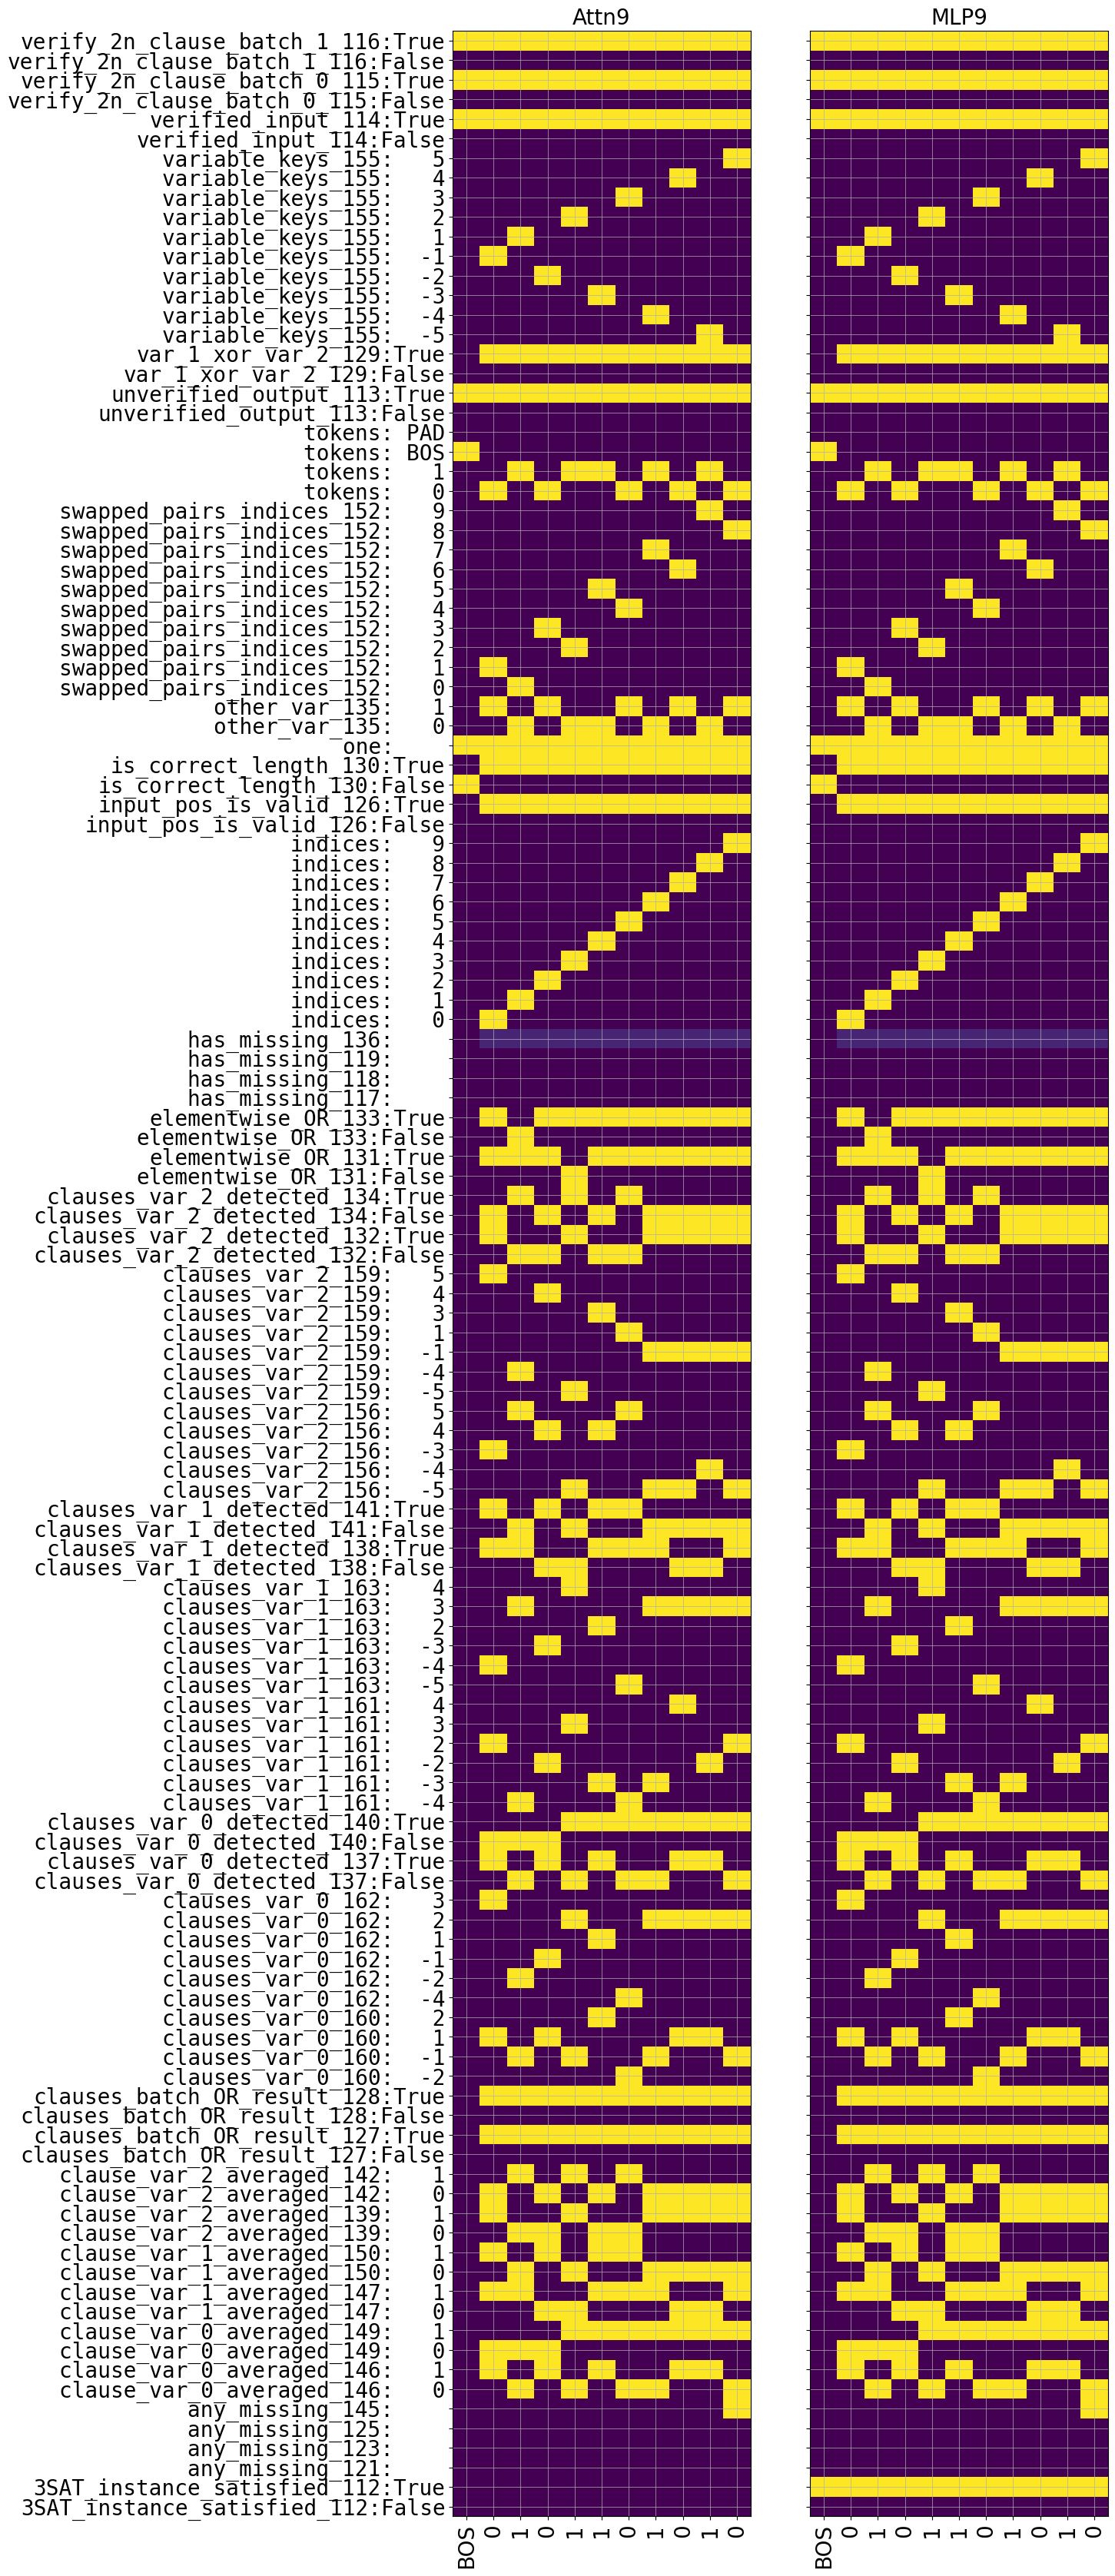

In [ ]:
#@title Plot final 2 residuals
plot_residuals_and_input(model=tracr_model, inputs=format_inputs(test_input), show_last_n_layers=2)

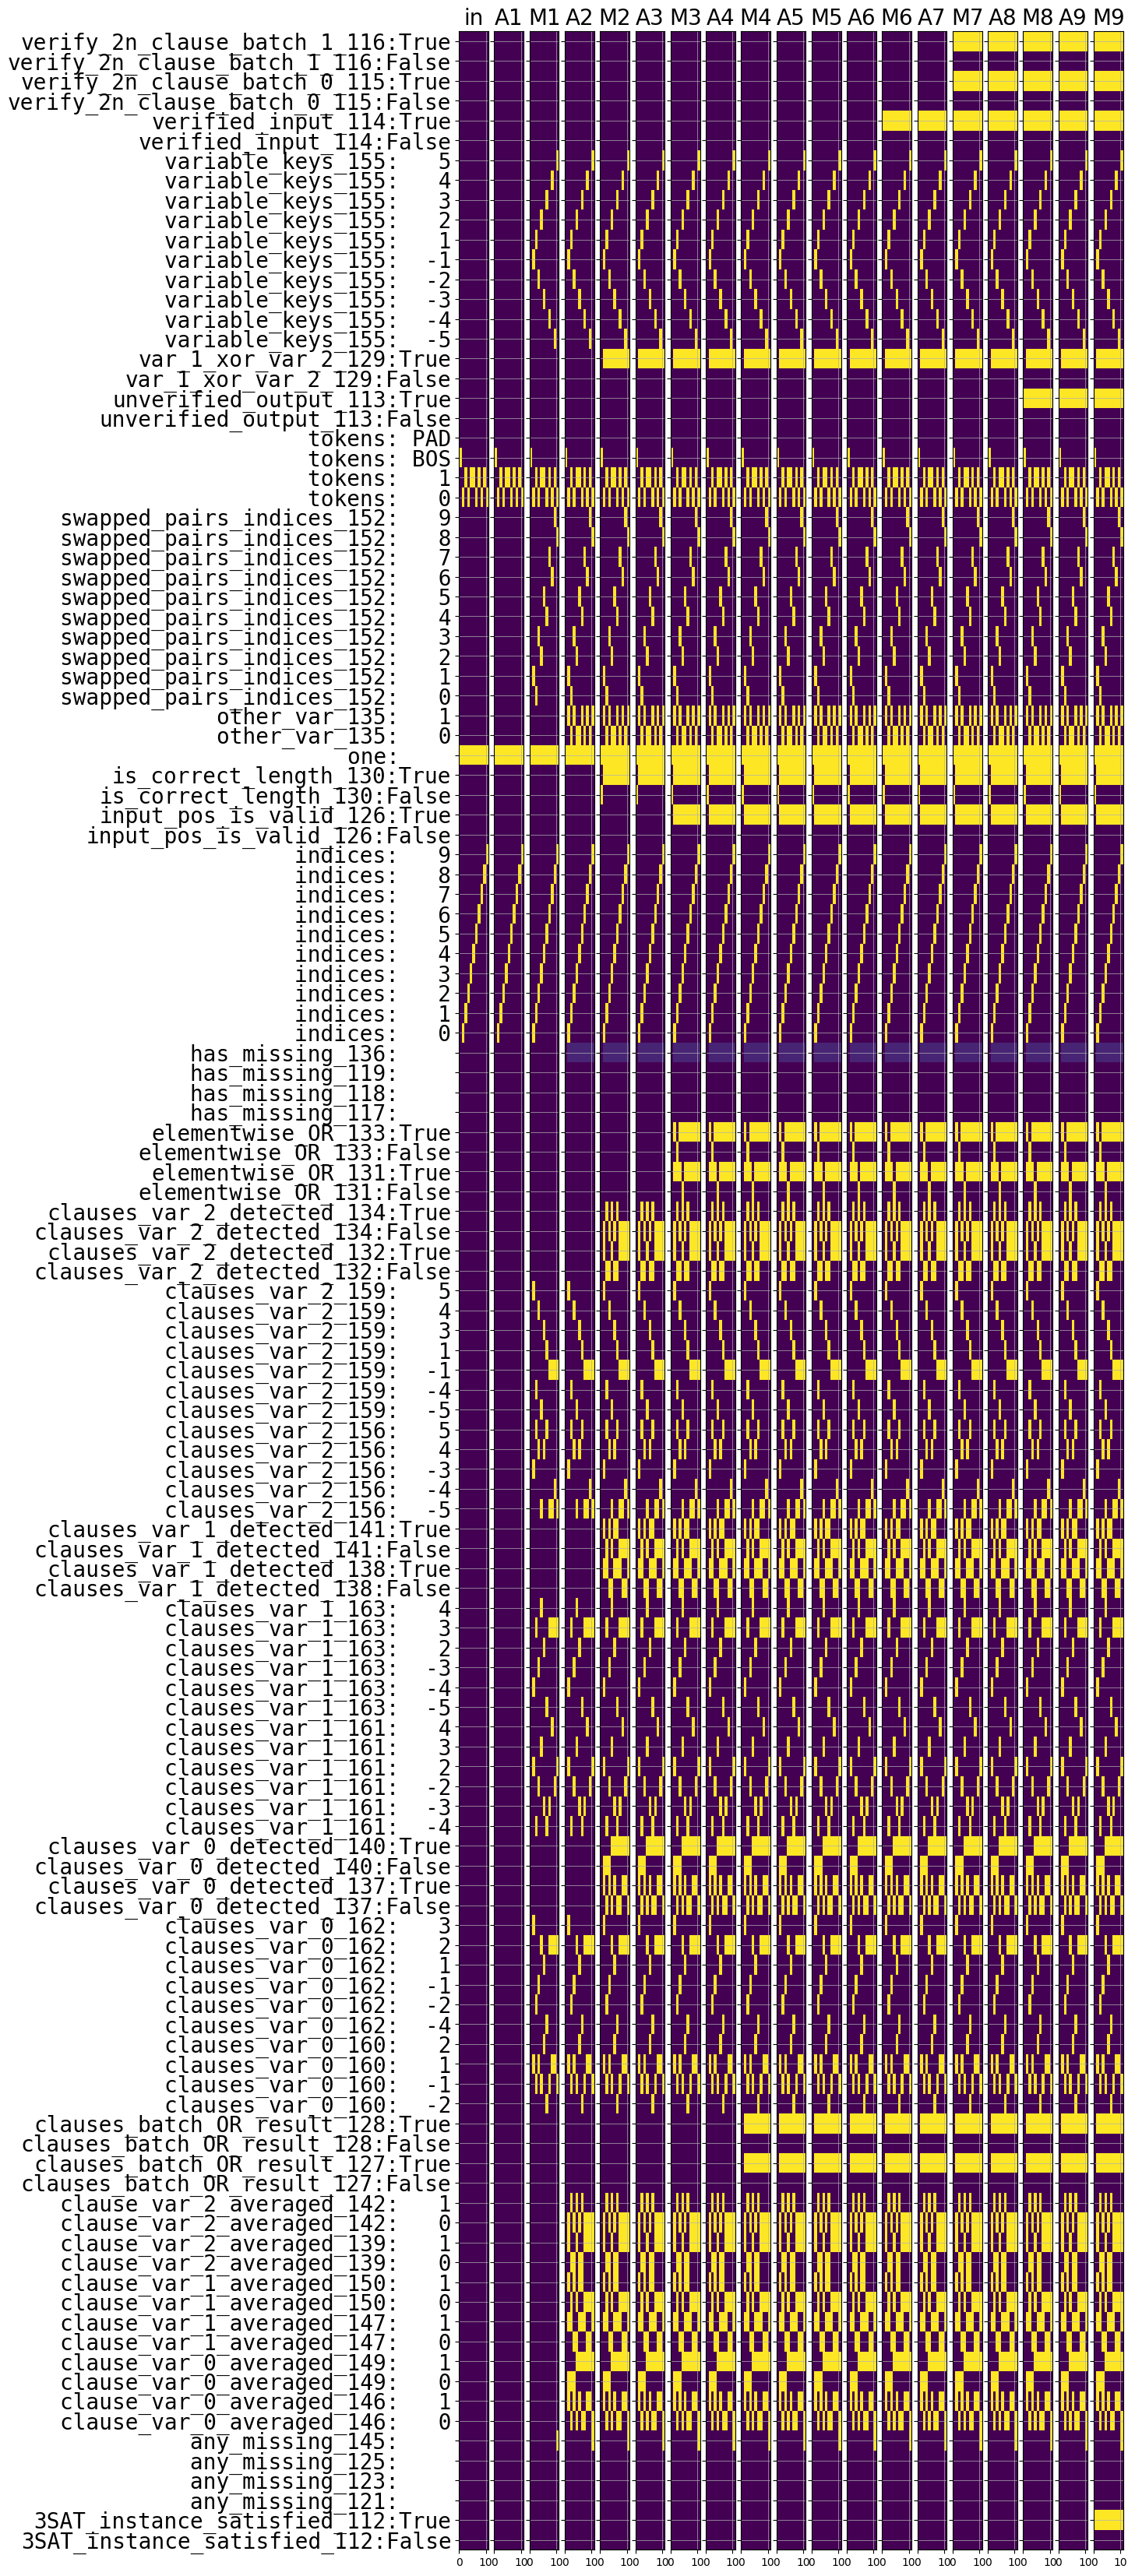

In [ ]:
#@title Plot residual stream
# plots the entire stream - can be slow
plot_residuals_and_input(model=tracr_model, inputs=format_inputs(test_input))

In [ ]:
#@title Plot layer outputs
# plot_layer_outputs(model=tracr_model, inputs = test_input_list)